In [1]:
# Source of code used here: J. Brownlee, “How to Develop a Pix2Pix GAN for Image-to-Image Translation,” 2019. [Online]. Available: https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/.
from PIL import Image
from os import listdir
from numpy import asarray
from numpy import savez_compressed
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model, Input, load_model
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.preprocessing.image import img_to_array, load_img
from matplotlib import pyplot
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from numpy import expand_dims

In [7]:
# Read the two images
for i in range(1,  105):
    image1 = Image.open(f'input/input_bolandmartabe_{i}.png')
    image2 = Image.open(f'output/output_bolandmartabe_{i}.png')
    image1 = image1.resize((600, 600))
    image2 = image2.resize((600, 600))
    image1_size = image1.size
    image2_size = image2.size
    new_image = Image.new('RGB', (2 * image1_size[0], image1_size[1]), (512, 512, 512))
    new_image.paste(image1, (0, 0))
    new_image.paste(image2, (image1_size[0], 0))
    new_image.save(f"in_out/in_out_{i}.jpg", "JPEG")

In [11]:
# load, split and scale the maps dataset ready for training

# load all images in a directory into memory
def load_images(path, size=(256, 512)):
    src_list, tar_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # split into satellite and map
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list), asarray(tar_list)]


# dataset path
path = 'in_out/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'test1.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (208, 256, 256, 3) (208, 256, 256, 3)
Saved dataset:  test1.npz


Loaded:  (208, 256, 256, 3) (208, 256, 256, 3)


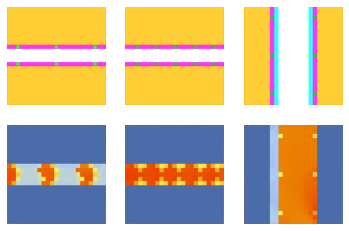

In [12]:
# load the prepared dataset

# load the dataset
data = load(filename)
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = initializers.RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model


# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = initializers.RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g


# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = initializers.RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g


# define the standalone generator model
def define_generator(image_shape=(256, 256, 3)):
    # weight initialization
    init = initializers.RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
    return model


# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]


# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y


# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples * 2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step + 1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step + 1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))


# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i + 1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i + 1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)


# load image data
dataset = load_real_samples(filename)
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

In [ ]:
# example of loading a pix2pix model and using it for one-off image translation

# load an image
def load_image(filename, size=(256, 256)):
    # load image with the preferred size
    pixels = load_img(filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1]
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = expand_dims(pixels, 0)
    return pixels

dir = 'input_test/'

# load source image
for file in listdir(dir):
    src_image = load_image('input_test/' + file)
    print('Loaded', src_image.shape)
    # load model
    model = load_model('codes/model_019000.h5')
    # generate image from source
    gen_image = model.predict(src_image)
    # scale from [-1,1] to [0,1]
    gen_image = (gen_image + 1) / 2.0
    # plot the image
    # pyplot.imshow(gen_image[0])
    # pyplot.axis('off')
    # pyplot.show()
    pyplot.imsave('output_test/output' + file[4:], gen_image[0])

In [6]:
# ### mesle bala ee bara ye ye aks

# load an image
def load_image(filename, size=(256, 256)):
    # load image with the preferred size
    pixels = load_img(filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1]
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = expand_dims(pixels, 0)
    return pixels

dir = 'input_test/'

# load source image

src_image = load_image(dir + 'test4.jpg')
print('Loaded', src_image.shape)
# load model
model = load_model('codes/model_019000.h5')
# generate image from source
gen_image = model.predict(src_image)
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
# plot the image
# pyplot.imshow(gen_image[0])
# pyplot.axis('off')
# pyplot.show()
pyplot.imsave('output_test/output_test4.jpg', gen_image[0])

Loaded (1, 256, 256, 3)


In [193]:
def load_image(filename, size=(256, 256)):
    # load image with the preferred size
    pixels = load_img(filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1]
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = expand_dims(pixels, 0)
    return pixels

dir = 'output_real/'
for file in listdir(dir):
    # load source image
    image1 = Image.open('output_real/' + file)
    # resize and save
    image1 = image1.resize((256, 256))
    image1.save('output_real_resize/' + file)

In [198]:
# USAGE
# python image_diff.py --first images/original_01.png --second images/modified_01.png

# import the necessary packages
from skimage.metrics import structural_similarity
import argparse
# import imutils
import cv2

dir1 = 'output_real_resize/'
dir2 = 'output_test/'
for file in listdir(dir):
    # load the two input images
    imageA = cv2.imread(dir1 + file)
    imageB = cv2.imread(dir2 + file)

    # convert the images to grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

    # compute the Structural Similarity Index (SSIM) between the two
    # images, ensuring that the difference image is returned
    (score, diff) = structural_similarity(grayA, grayB, full=True)
    diff = (diff * 255).astype("uint8")
    print(f"SSIM for {file}: {score}")

SSIM for output_bolandmartabe_10.png: 0.9693967656337901
SSIM for output_bolandmartabe_23.png: 0.969407901803056
SSIM for output_bolandmartabe_26.png: 0.9667644985884282
SSIM for output_bolandmartabe_62.png: 0.963852744214736
SSIM for output_bolandmartabe_73.png: 0.9539122653149542
SSIM for output_bolandmartabe_91.png: 0.9443708806847759
SSIM for output_bolandmartabe_95.png: 0.9684330077193106
SSIM for output_kotahmartabe_104.png: 0.967732650039777
SSIM for output_kotahmartabe_13.png: 0.9672435996546561
SSIM for output_kotahmartabe_17.png: 0.9505993289557377
SSIM for output_kotahmartabe_2.png: 0.9479788963578804
SSIM for output_kotahmartabe_23.png: 0.9708025989764844
SSIM for output_kotahmartabe_41.png: 0.9499835530231575
SSIM for output_kotahmartabe_48.png: 0.9691811442054106
SSIM for output_kotahmartabe_5.png: 0.954687971161254
SSIM for output_kotahmartabe_58.png: 0.9525009691867481
SSIM for output_kotahmartabe_74.png: 0.9679284825144657
SSIM for output_kotahmartabe_86.png: 0.9550190

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
amar = pd.read_csv('jadvale_eng.csv', encoding = "ISO-8859-1")
print(type(amar))
amar.head()

<class 'pandas.core.frame.DataFrame'>


,halat \ shomare,Building height,Orientation,Street width,Number of trees,Tree type,Water bodies,Pavement material,Façade type,min UTCI,max UTCI,average UTCI,standard deviation
0,1,Low rise,East to west,10,3,1,0,1,Brick,28.981508,36.642957,31.998827,2.832674
1,2,Low rise,East to west,14,3,1,0,1,Brick,29.009238,36.871503,32.887224,2.877221
2,3,Low rise,East to west,22,3,1,0,1,Brick,29.173742,37.166184,34.385242,2.805262
3,4,Low rise,East to west,10,5,1,0,1,Brick,28.289377,36.314367,29.831609,1.872438
4,5,Low rise,East to west,14,5,1,0,1,Brick,28.168371,36.543911,30.867662,2.376272


<function matplotlib.pyplot.show(close=None, block=None)>

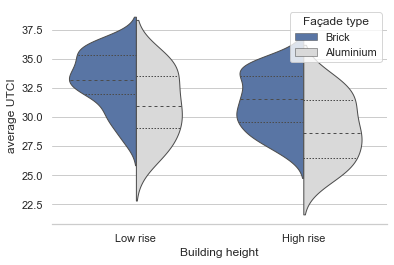

In [4]:
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Draw a nested violinplot and split the violins for easier comparison
nemo = sns.violinplot(data=amar, x="Building height", y="average UTCI", hue="Façade type", split=True, inner="quart", linewidth=1, palette={'Brick': "b", 'Aluminium': ".85"})
sns.despine(left=True)

plt.show

In [ ]:
sns.set_theme(style="whitegrid")

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=amar, x="ٌWater bodies", y="average UTCI", inner="quart", linewidth=1)
sns.despine(left=True)

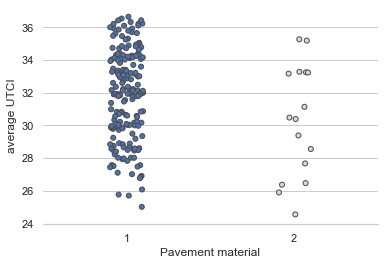

In [161]:
sns.set_theme(style="whitegrid")


sns.stripplot(data=amar, x="Pavement material", y="average UTCI", linewidth=1, palette={1: "b", 2: ".85"})
sns.despine(left=True)

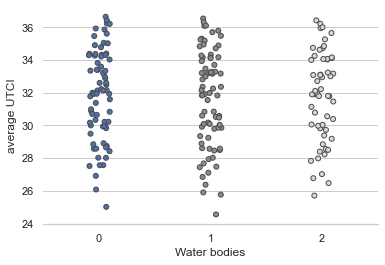

In [152]:
sns.set_theme(style="whitegrid")

# Draw a nested violinplot and split the violins for easier comparison
sns.stripplot(data=amar, x="Water bodies", y="average UTCI", linewidth=1, palette={0: "b", 2: ".85", 1:'.55'})
sns.despine(left=True)

<AxesSubplot:xlabel='Street width', ylabel='average UTCI'>

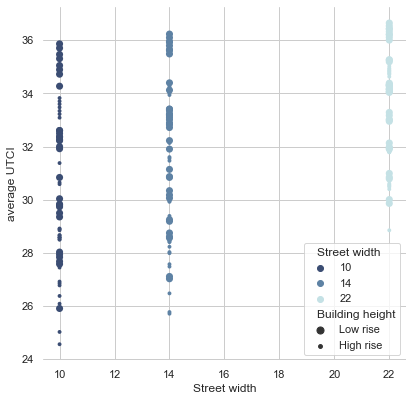

In [82]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x="Street width", y="average UTCI",
                hue="Street width", size="Building height",
                palette="ch:r=-.2,d=.3_r",
                sizes=(15, 50), linewidth=0,
                data=amar, ax=ax)

In [23]:
amar.loc[amar['Façade type'] != 'Brick'].describe()

,halat \ shomare,Street width,Number of trees,Tree type,Water bodies,Pavement material,min UTCI,max UTCI,average UTCI,standard deviation
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,114.500000,15.666667,5.166667,1.500000,1.000000,1.333333,25.630318,34.794196,30.050626,2.761107
std,58.856479,4.799527,1.534474,0.505291,0.825137,0.476393,2.041653,1.187048,2.979184,0.686555
min,31.000000,10.000000,3.000000,1.000000,0.000000,1.000000,22.757840,32.467586,24.557463,1.175960
25%,72.750000,13.000000,4.500000,1.000000,0.000000,1.000000,24.239103,34.018617,27.906934,2.156827
50%,114.500000,14.000000,5.000000,1.500000,1.000000,1.000000,25.298587,34.745383,30.018555,2.831890
75%,156.250000,22.000000,7.000000,2.000000,2.000000,2.000000,26.268541,35.599847,32.154972,3.336080
max,198.000000,22.000000,7.000000,2.000000,2.000000,2.000000,30.524546,36.948987,35.267121,3.747965


In [105]:
amar.head()

,halat \ shomare,Building height,Orientation,Street width,Number of trees,Tree type,Water bodies,Pavement material,Façade type,min UTCI,max UTCI,average UTCI,standard deviation
0,1,Low rise,East to west,10,3,1,0,1,Brick,28.981508,36.642957,31.998827,2.832674
1,2,Low rise,East to west,14,3,1,0,1,Brick,29.009238,36.871503,32.887224,2.877221
2,3,Low rise,East to west,22,3,1,0,1,Brick,29.173742,37.166184,34.385242,2.805262
3,4,Low rise,East to west,10,5,1,0,1,Brick,28.289377,36.314367,29.831609,1.872438
4,5,Low rise,East to west,14,5,1,0,1,Brick,28.168371,36.543911,30.867662,2.376272


In [164]:
piyadero = pd.read_csv('jadvale_eng - Copy.csv', encoding = "ISO-8859-1")

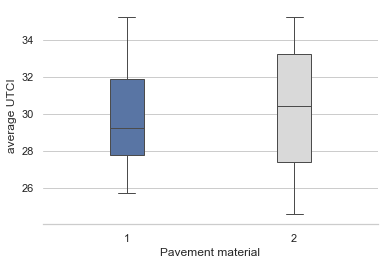

In [169]:
sns.set_theme(style="whitegrid")

# Draw a nested violinplot and split the violins for easier comparison
sns.boxplot(data=piyadero, x="Pavement material", y="average UTCI", width=0.2, linewidth=1, palette={1: "b", 2: ".85"})
sns.despine(left=True)

In [183]:
1

1